In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Function to create the LSTM model
def create_model(dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Download stock data
ticker = 'AAPL'  # Apple Inc.
start_date = '2010-01-01'
end_date = '2023-08-01'

data = yf.download(ticker, start=start_date, end=end_date)
df = data[['Close']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

[*********************100%%**********************]  1 of 1 completed


In [15]:
# Create sequences for LSTM
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Grid search for hyperparameter tuning
param_grid = {
    'batch_size': [16,32,64],
    'epochs': [20,50,100],
    'model__dropout_rate': [0.1,0.2,0.4]  
}

model = KerasRegressor(model=create_model, verbose=0)  
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best parameters: ", grid_result.best_params_)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters:  {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2}


In [16]:
# Train the best model
best_params = grid_result.best_params_
best_model = create_model(dropout_rate=best_params['model__dropout_rate'])  # Changed this line
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'],
                       batch_size=best_params['batch_size'], verbose=1)

# Make predictions
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0035
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 4.9647e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 4.1446e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 3.6313e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 4.3407e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 3.3387e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 2.9742e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 2.8036e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 3.3422e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 2.7655e-04
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 2.5922e-04
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 2.5274e-04
Epoch 13/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 2.3000e-04
Epoch 14/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 3.3431e-04
Epoch 15/50
84/84 

In [17]:
# Calculate error metrics
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f"\nTrain MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")



Train MSE: 4.11, Test MSE: 72.41
Train MAE: 1.68, Test MAE: 7.60
Train R²: 0.99, Test R²: 0.78


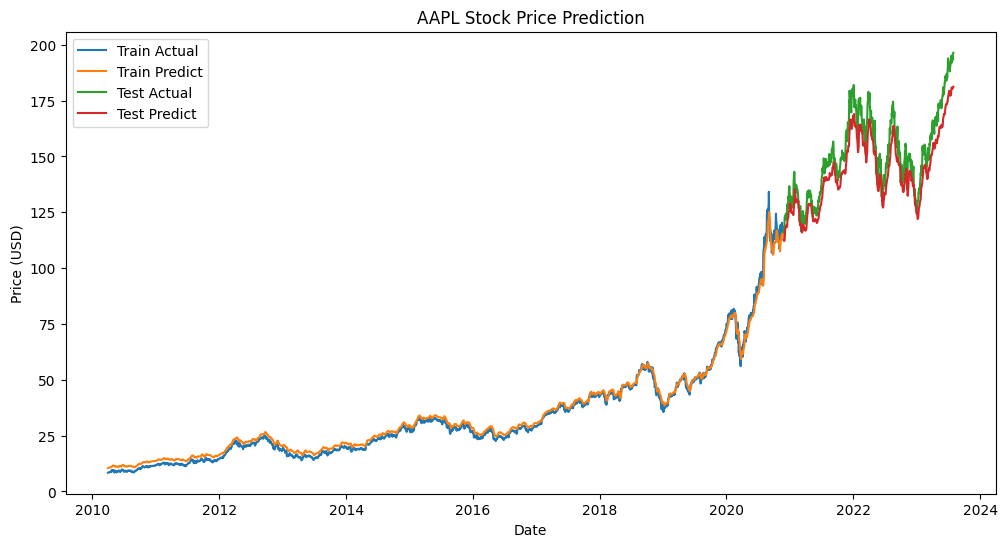

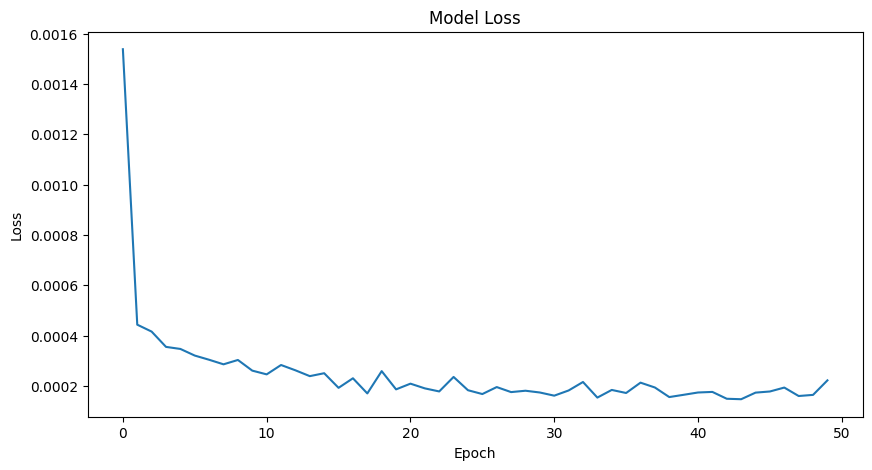

In [18]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[sequence_length:train_size+sequence_length], y_train_actual, label='Train Actual')
plt.plot(df.index[sequence_length:train_size+sequence_length], train_predict, label='Train Predict')
plt.plot(df.index[train_size+sequence_length:], y_test_actual, label='Test Actual')
plt.plot(df.index[train_size+sequence_length:], test_predict, label='Test Predict')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [19]:
# After training and evaluating your model
import joblib

# Save the model
best_model.save('lstm_stock_predictor.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save some additional info
model_info = {
    'ticker': ticker,
    'start_date': start_date,
    'end_date': end_date,
    'sequence_length': sequence_length,
    'best_params': best_params
}
joblib.dump(model_info, 'model_info.pkl')

['model_info.pkl']

In [20]:
# Save the model in .keras format
best_model.save('lstm_stock_predictor.keras', save_format='keras')
print(f"Model saved as 'lstm_stock_predictor.keras'")

Model saved as 'lstm_stock_predictor.keras'
